# Challenge Markov Chain Monte Carlo

### General Imports

In [2]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from src.preprocess_data import generate_data, visualize_data

### Load Data and Define Density

In [3]:
dtype = np.float32
data = pd.read_csv("src/samples_1.csv", index_col = "Unnamed: 0").to_numpy()

def target_log_prob(param):

    '''
    Log density of our GMM. No need to change here anything.
    '''

    mu_1, mu_2, sigma_1, sigma_2 = param
    
    log_dens = tf.math.reduce_sum(tf.math.log(
        1/(2*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
        1/(2*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2))) - 0.5 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    
    return(log_dens)

### User Inputs

Change Stuff here. To begin leave everything as is.

- *init_state*, our Markov Chain starts here, ideally our Markov Chain starts around the *true values*. init_state = [mu_1, mu_2, sigma_1, sigma_2].
- *num_samples*, how many samples should we generate, please stay around 1000 samples so that the code doesn't take forever to run. For debugging/ experiments you might want to take a lower number of samples.
- *num_burnin*, how many samples should we discard for the burnin?
- *kernel*, which kernel should we use. The Kernel is the MCMC algorithm, so for example MALA or NUTS.

In [62]:
init_state = dtype([2, 2, 2, 2])
num_samples = 300
num_burnin = 50
kernel = tfp.mcmc.HamiltonianMonteCarlo(
         target_log_prob_fn=target_log_prob,
         step_size=0.04,
         exploration_shrinkage=0.05,
         step_count_smoothing=10,
         decay_rate=0.75)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin * 0.8))

TypeError: DualAveragingStepSizeAdaptation.__init__() got an unexpected keyword argument 'target_log_prob_fn'

### Generate Samples

This takes some time, in the standard configuration around 40 Seconds on my computer.

In [57]:
#Generate Samples
start_time = time.time()
samples = tfp.mcmc.sample_chain(
num_results=num_samples,
current_state=init_state,
kernel=kernel,
num_burnin_steps=num_burnin,
trace_fn=None,
seed=42)
end_time = time.time()

### Traceplots

Check qualitatively how your sampler performs.

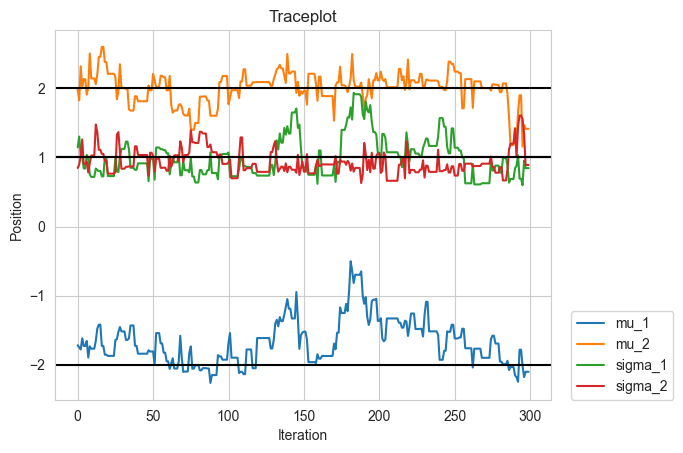

In [58]:
plt.title('Traceplot')
plt.plot(samples.numpy())
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.legend(["mu_1", "mu_2", "sigma_1", "sigma_2"], loc=(1.04, 0))
plt.axhline(y=-2, color='black', linestyle='-')
plt.axhline(y=2, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

### Evaluation

Check quantitatively how your sampler performs.

In [59]:
sample_mean = tf.reduce_mean(samples, axis=0).numpy()
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0)).numpy()

true_values = [-2, 2, 1, 1]
effective_sample_size = tfp.mcmc.effective_sample_size(samples).numpy()
ESS_mean = round(np.mean(effective_sample_size))
duration_sec = end_time - start_time
Ess_per_sec = round(ESS_mean/duration_sec, 2)


print('Sample Mean:', sample_mean.round(2))
print('Sample Standard Deviation:', sample_std.round(2))
print('True Values:', true_values)
print('Average Effective Sample Size:', ESS_mean)
print('Average ESS per Second:', Ess_per_sec)

Sample Mean: [-1.67  2.    1.    0.93]
Sample Standard Deviation: [0.33 0.24 0.3  0.18]
True Values: [-2, 2, 1, 1]
Average Effective Sample Size: 20
Average ESS per Second: 1.18


### Your Turn

Now it's your turn to achieve a better performance by *changing the sampling method*. Please leave all cells as they are except for the *User Inputs* cell.

To start, think about changing the following:

- *num_burnin*, currently the burnin is very low (check out the trace plot!), how about taking a larger value? Don't forget that taking a too high value negatively impacts performance (because we discard high-quality samples).
- *init_state*, ideally our chain already starts close to the true values, can you automatically estimate them from the data?

Next up you could work on:

- *kernel*, try the other kernels from the presentation or a completely new Kernel. You can find a list of all TFP kernels [here](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc).
- *hyperparameters*, in the current version we set *step_size = 0.03*, experiment with different values or start looking into [automatic hyperparameter tuning](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/DualAveragingStepSizeAdaptation). Note: Automatic hyperparameter tuning needs an optimal acceptance probability which depends on the kernel. Ask Paul or Leon directly for further ideas on this.

And if you have lots of time:

- Incorporate prior knowledge by changing the prior distributions. This is slightly more complicated but very interesting. You can find more details [here](src/priors.md).

<br/><br/>
<br/><br/>

Submission:

Just send us this notebook and we will run it on our hardware. We will have a live leaderboard so you can see how you perform against other teams. So please send us your results regularly to keep the challenge exciting for everyone!


<br/><br/>
<br/><br/>

You can generate more data and visualize it with code from [this file](src/preprocess_data.py):


```python
new_data = generate_data(num_samples = 50, num_modes = 2, mu = [-2, 2], sigma = [1, 1], name = None)

visualize_data(new_data)
```
Please stay around 50 samples as the algorithms might become numerically unstable for more samples (Bonus Points if you tell us why, Extra Bonus Points if you manage to build numerically stable algorithms for a high amount of samples (> 1000)).

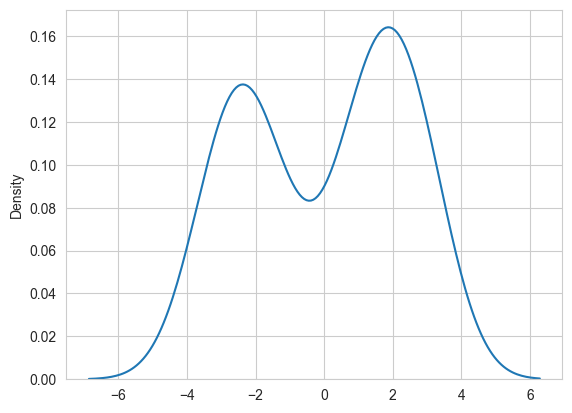

In [60]:
new_data = generate_data(num_samples = 50, num_modes = 2, mu = [-2, 2], sigma = [1, 1], name = None)

visualize_data(new_data)